In [3]:
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.colors as pltcolors

from sklearn.datasets import make_blobs
from sklearn.svm import SVC

from cvxopt import matrix, solvers

from quantum_svm.data.data_generators import create_bipolar_data, create_XOR_data, create_moons_data, create_circles_data, adhoc_dataset
from quantum_svm.svm.linear_classifier import linearSVC
from quantum_svm.svm.nonlinear_classifier import kernelSVC
from quantum_svm.utils.plot import (
    plot_data, 
    plot_confusion_matrix, 
    plot_SVM, 
    plot_datasets, 
    plot_adhoc, 
    plot_kernel_SVC
)
from quantum_svm.utils.utils import accuracy
from quantum_svm.quantum.quantum_kernels import quantum_kernel
%load_ext autoreload

%autoreload 2

In [4]:
alpha_tol = 1e-04
colors = ['red', 'blue']
cmap_custom = pltcolors.ListedColormap(colors)
cmap = plt.cm.RdBu_r


seed = 12

#### Datasets

In [5]:
params_bipolar_hard = {
    'N': 200, # number of samples
    'D': 2, # number of dimensions
    'C': 2, # number of classes 
    'sigma': 0.5, # std
    'seed': seed,
}

params_bipolar_soft = {
    'N': 200, # number of samples
    'D': 2, # number of dimensions
    'C': 2, # number of classes 
    'sigma': 1.2, # std
    'seed': seed,
}

center = 1
params_xor = {
    'N': 100, # number of samples
    'D': 2, # number of dimensions
    'sigma': 0.4, # std
    'centers': [[center,center], [-center,center], [center,-center], [-center,-center]], 
    'seed': seed,
}


params_circles = {
    'N': 200, # number of samples
    'factor': 0.4, 
    'noise': 0.1,
    'seed': seed,
}

params_moons = {
    'N': 200, # number of samples
    'noise': 0.15,
    'seed': seed,
}

params_adhoc = {
    'train_size': 40,
    'test_size': 10,
    'adhoc_dimension': 2,
    'gap': 0.3,
}

In [6]:
datasets = [
    create_bipolar_data(
        params_bipolar_hard['N'], 
        params_bipolar_hard['D'], 
        params_bipolar_hard['C'], 
        params_bipolar_hard['sigma'], 
        params_bipolar_hard['seed']
    ),
    create_bipolar_data(
        params_bipolar_soft['N'], 
        params_bipolar_soft['D'], 
        params_bipolar_soft['C'], 
        params_bipolar_soft['sigma'], 
        params_bipolar_soft['seed']
    ),
    create_XOR_data(
        params_xor['N'], 
        params_xor['D'], 
        params_xor['centers'], 
        params_xor['sigma'], 
        params_xor['seed']
    ),
    create_circles_data(
        params_circles['N'], 
        params_circles['factor'], 
        params_circles['noise'], 
        params_circles['seed']
    ),
    create_moons_data(
        params_moons['N'], 
        params_moons['noise'], 
        params_moons['seed']
    ),
    adhoc_dataset(
        params_adhoc['train_size'], 
        params_adhoc['test_size'], 
        params_adhoc['adhoc_dimension'],
        params_adhoc['gap']
    ),
]

plot_titles = [
    'Linearaly Seperable Data - large margin',
    'Linearaly Seperable Data - no margin',
    'XOR Data',
    'Circles Data',
    'Moons Data', 
    'Adhoc Data'
]

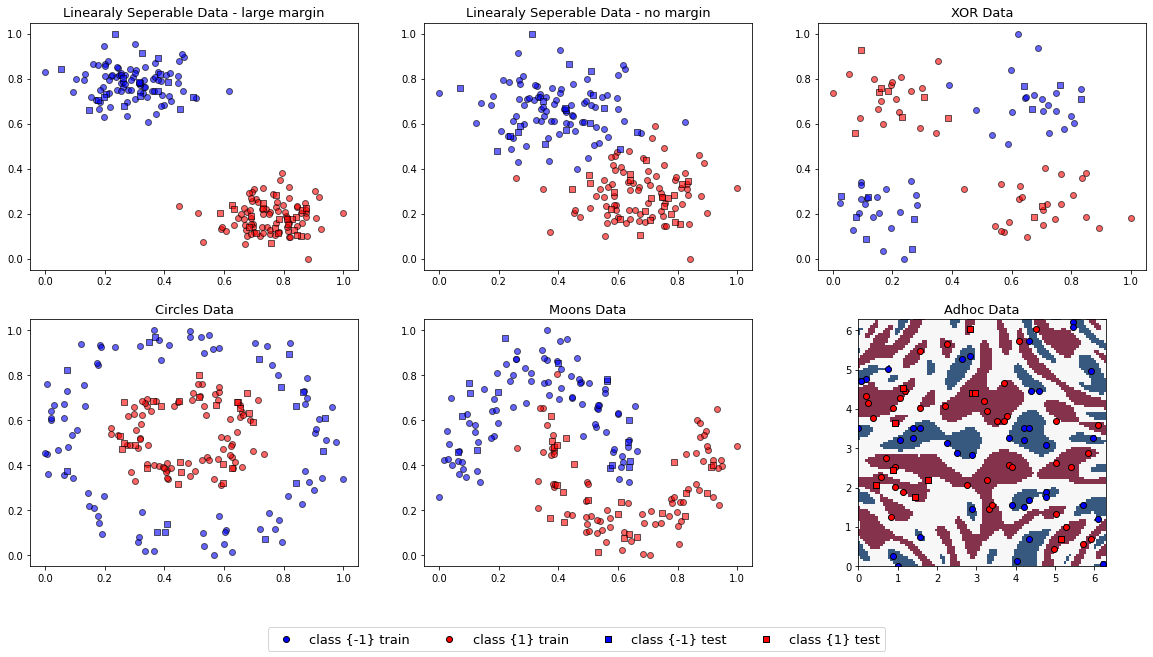

In [7]:
plot_datasets(datasets, plot_titles)

#### Base-Line Models 

In [8]:
baseline_hard_margin_SVC = SVC(kernel='linear', C=10000)
baseline_soft_margin_SVC = SVC(kernel='linear', C=10)
baseline_linear_kernel_SVC = SVC(kernel='linear', C=10)
baseline_poly_kernel_SVC = SVC(kernel='poly', C=10, degree=3)
baseline_rbf_kernel_SVC = SVC(kernel='rbf', C=10, gamma=0.5)

## Hard Margin SVM

In [179]:
# Load data
X_bi_train, X_bi_test, y_bi_train, y_bi_test = datasets[0]

# Initialize Model 
hard_margin_SVC = linearSVC()

In [180]:
# Fit Model
hard_margin_SVC.fit(X_bi_train, y_bi_train)
params = hard_margin_SVC.compute_params()

Found 3 Support Vectors out of 160 data points


Weights: [ 2.03731128 -4.75300436]
Bias: 1.1954408506619825
Decision Hyperplane: 0.4286365255878248 * x + 0.25151267684329354 


Accuracy on train set: 100.0 %


In [181]:
# Precict
y_pred_hard_margin = hard_margin_SVC.predict(X_bi_test)

In [182]:
# baseline
baseline_hard_margin_SVC.fit(X_bi_train, y_bi_train)

SVC(C=10000, kernel='linear')

In [183]:
y_pred_baseline_hard_margin = baseline_hard_margin_SVC.predict(X_bi_test)
baseline_acc_hard_margin= baseline_hard_margin_SVC.score(X_bi_test, y_bi_test)

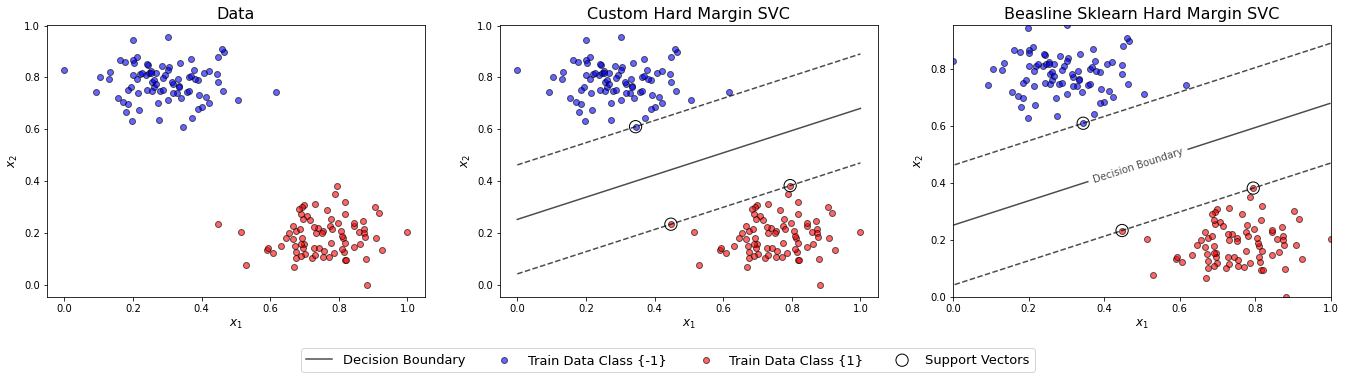

In [184]:
plot_SVM(
    X_bi_train, 
    y_bi_train, 
    params, 
    baseline_hard_margin_SVC, 
    titles = ["Data", "Custom Hard Margin SVC", "Beasline Sklearn Hard Margin SVC"],
    sv=True, 
    hyperplane=True)

Accuracy on test set: 100.0 %
Baseline Accuracy: 100.0 %


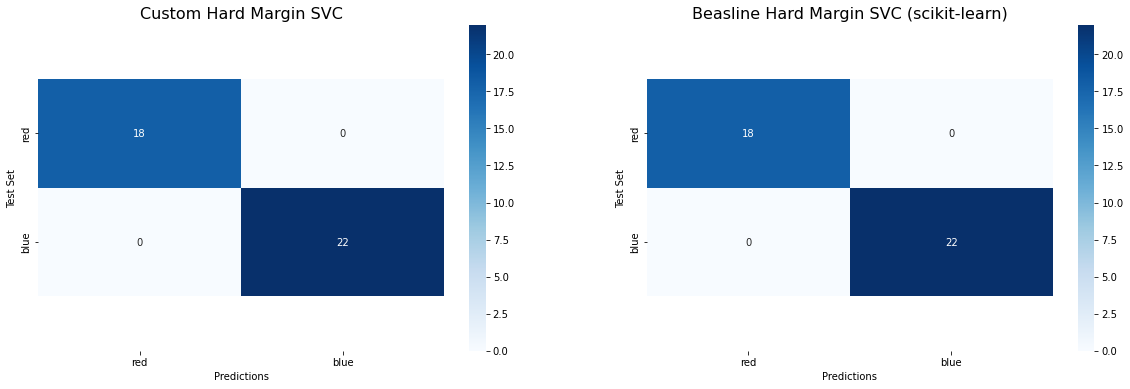

In [186]:
# accuracy
accuracy(y_bi_test, y_pred_hard_margin, True, mode='test')
print(f'Baseline Accuracy: {baseline_acc_hard_margin*100} %')

# confusion Matrix plot
plot_confusion_matrix(
    y_bi_test, 
    y_pred_hard_margin,
    y_pred_baseline_hard_margin,
    colors, 
    titles=["Custom Hard Margin SVC", "Beasline Hard Margin SVC (scikit-learn)"]
)

## Soft Margin SVM

In [187]:
# Load Data
X_bi_2_train, X_bi_2_test, y_bi_2_train, y_bi_2_test = datasets[1]

# Initialize Model
soft_margin_SVC = linearSVC(C=10)
# Fit Model
soft_margin_SVC.fit(X_bi_2_train, y_bi_2_train)
params = soft_margin_SVC.compute_params()

Found 24 Support Vectors out of 160 data points


Weights: [ 5.14872057 -8.55166523]
Bias: 1.249749573971498
Decision Hyperplane: 0.6020722791139658 * x + 0.14614107791459807 


Accuracy on train set: 97.5 %


In [188]:
# Predict
y_pred_soft_margin = soft_margin_SVC.predict(X_bi_2_test)

In [189]:
# baseline 
baseline_soft_margin_SVC.fit(X_bi_2_train, y_bi_2_train)

SVC(C=10, kernel='linear')

In [190]:
y_pred_baseline_soft_margin = baseline_soft_margin_SVC.predict(X_bi_2_test)
baseline_acc_soft_margin = baseline_soft_margin_SVC.score(X_bi_2_test, y_bi_2_test)

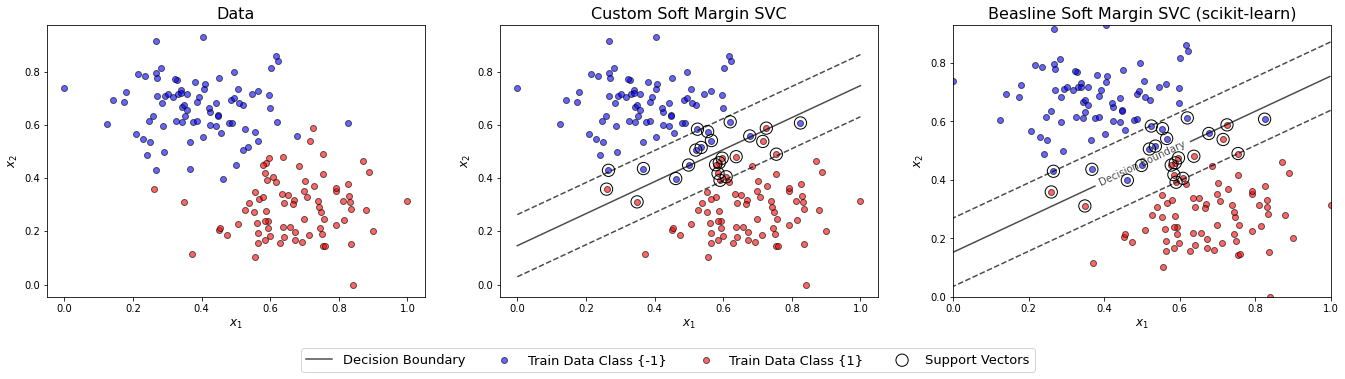

In [191]:
plot_SVM(
    X_bi_2_train, 
    y_bi_2_train,  
    params, 
    baseline_soft_margin_SVC, 
    titles = ["Data", "Custom Soft Margin SVC", "Beasline Soft Margin SVC (scikit-learn)"],
    sv=True, 
    hyperplane=True)

Accuracy on test set: 100.0 %
Baseline Accuracy: 97.5 %


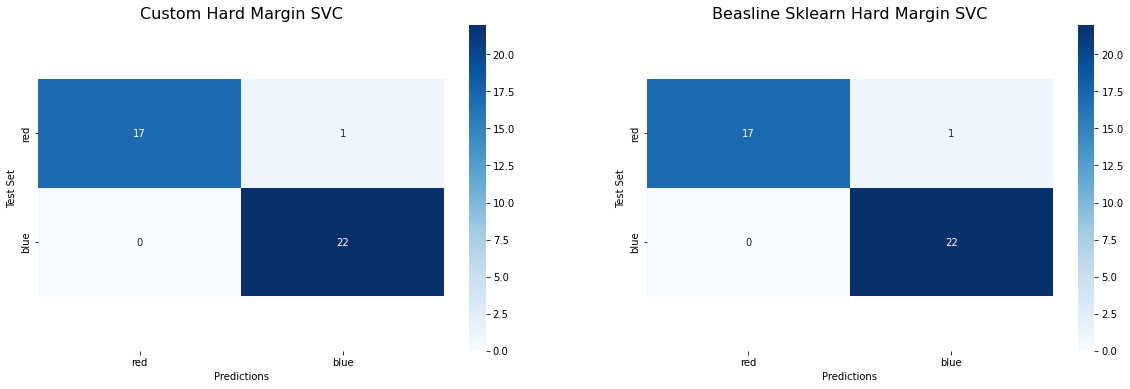

In [193]:
# accuracy
accuracy(y_pred_soft_margin, y_pred_baseline_soft_margin, True, mode='test')
print(f'Baseline Accuracy: {baseline_acc_soft_margin*100} %')

# confusion Matrix plot
plot_confusion_matrix(
    y_bi_2_test, 
    y_pred_soft_margin,
    y_pred_baseline_soft_margin,
    colors, 
    titles=["Custom Hard Margin SVC", "Beasline Sklearn Hard Margin SVC"]
)

### What if data is not linearly seperable ? 

In [59]:
# Load Data
X_xor_train, X_xor_test, y_xor_train, y_xor_test = datasets[2]

# Initialize Model
linear_SVC = kernelSVC(None, kernel='linear', C=10)
# Fit Model
linear_SVC.fit(X_xor_train, y_xor_train)

SVC(kernel=linear, C=10.0)
Found 74 Support Vectors out of 80 data points




100%|██████████████████████████████████████| 80/80 [00:00<00:00, 4646.59batch/s]


Accuracy on training set: 53.75 %


In [195]:
# Predict
y_pred_linear_SVC = linear_SVC.predict(X_xor_test)

100%|██████████████████████████████████████| 20/20 [00:00<00:00, 1914.77batch/s]


In [196]:
# baseline 
baseline_soft_margin_SVC.fit(X_xor_train, y_xor_train)

SVC(C=10, kernel='linear')

In [197]:
# predict
y_pred_baseline_soft_margin_xor = baseline_soft_margin_SVC.predict(X_xor_test)
baseline_acc_soft_margin_xor = baseline_soft_margin_SVC.score(X_xor_test, y_xor_test)

100%|██████████████████████████████████| 2500/2500 [00:00<00:00, 5649.48batch/s]


[[0.59823697 0.83957035]
 [0.67477869 0.72986343]
 [0.58591827 0.50914678]
 [0.74651093 0.65701683]
 [0.60142706 0.65388642]
 [0.74936156 0.73619501]
 [0.79975376 0.63457984]
 [0.17761776 0.31102383]
 [0.13595893 0.18592206]
 [0.72375975 0.55862618]
 [0.26235427 0.34415076]
 [0.1678977  0.03222835]
 [0.72104954 0.68569174]
 [0.14684107 0.27562219]
 [0.09465969 0.26663537]
 [0.09588611 0.32598036]
 [0.64339952 0.7125741 ]
 [0.10707338 0.24498739]
 [0.64768997 0.71900791]
 [0.1553265  0.20194611]
 [0.77415789 0.574651  ]
 [0.23745273 0.        ]
 [0.83165979 0.75355236]
 [0.62019888 1.        ]
 [0.70332992 0.65735279]
 [0.53387281 0.55019374]
 [0.28195154 0.23740651]
 [0.70034086 0.71118746]
 [0.08743833 0.20332968]
 [0.06615902 0.12784157]
 [0.807988   0.60549636]
 [0.11361784 0.26753462]
 [0.68849417 0.939188  ]
 [0.19403161 0.13508792]
 [0.22637291 0.20639058]
 [0.27903859 0.28208233]
 [0.48090149 0.66029826]
 [0.35160293 0.88075507]
 [0.4413334  0.31149669]
 [0.26129014 0.74429103]


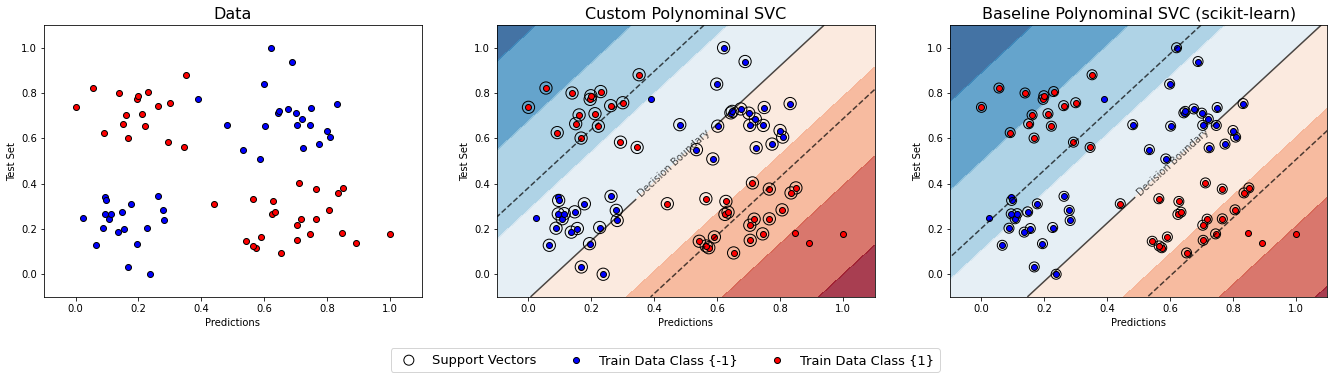

In [198]:
plot_kernel_SVC(
    X_xor_train, 
    y_xor_train, 
    [linear_SVC, baseline_soft_margin_SVC],
    cmap, 
    titles=["Data", "Custom Polynominal SVC", "Baseline Polynominal SVC (scikit-learn)"], 
    kernel='polynominal')

In [200]:
# accuracy
accuracy(y_xor_test, y_pred_linear_SVC, True, mode='test')
print(f'Baseline Accuracy: {baseline_acc_soft_margin_xor*100} %')

Accuracy on test set: 35.0 %
Baseline Accuracy: 50.0 %


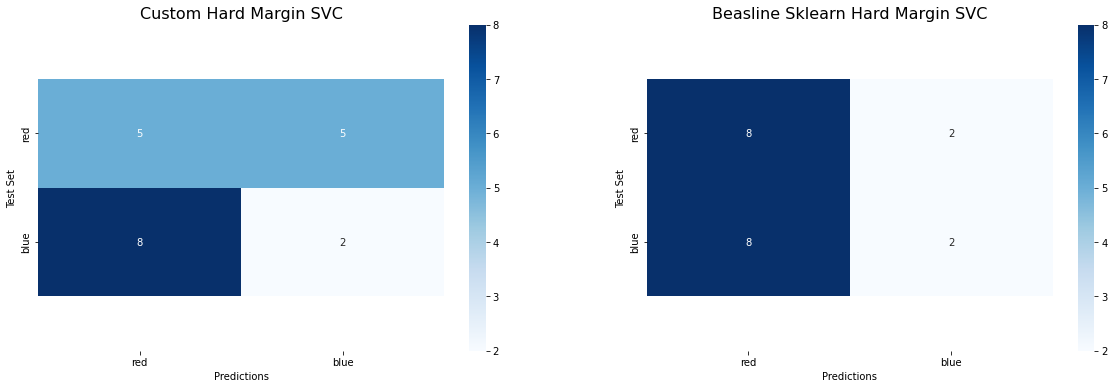

In [201]:
# confusion Matrix plot
plot_confusion_matrix(
    y_xor_test, 
    y_pred_linear_SVC,
    y_pred_baseline_soft_margin_xor,
    colors, 
    titles=["Custom Hard Margin SVC", "Beasline Sklearn Hard Margin SVC"]
)

## Kernel Methods

### Polynominal Kernel

In [202]:
# Initialize Polynominal SVC
polynominal_SVC = kernelSVC(None, kernel='polynominal', C=10, degree=3)

# Fit Model
polynominal_SVC.fit(X_xor_train, y_xor_train)

SVC(kernel=polynominal, C=10.0, degree=3)
P: (80, 80)
q: (80, 1)
G: (160, 80)
h: (160, 1)
A: (1, 80)
b: (1, 1)
Found 22 Support Vectors out of 80 data points




100%|██████████████████████████████████████| 80/80 [00:00<00:00, 8972.49batch/s]


Accuracy on training set: 96.25 %


In [203]:
y_xor_pred_poly = polynominal_SVC.predict(X_xor_test)

100%|██████████████████████████████████████| 20/20 [00:00<00:00, 7610.10batch/s]


In [204]:
# baseline 
baseline_poly_kernel_SVC.fit(X_xor_train, y_xor_train)

SVC(C=10, kernel='poly')

In [205]:
y_xor_pred_baseline_poly = baseline_poly_kernel_SVC.predict(X_xor_test)
baseline_acc_poly = baseline_poly_kernel_SVC.score(X_xor_test, y_xor_test)

100%|█████████████████████████████████| 2500/2500 [00:00<00:00, 14078.23batch/s]


[[0.09408606 0.34224971]
 [0.09588611 0.32598036]
 [0.77415789 0.574651  ]
 [0.23745273 0.        ]
 [0.38923594 0.77444756]
 [0.02492574 0.24631531]
 [0.4413334  0.31149669]
 [0.3453359  0.55988482]
 [0.29246511 0.58318028]
 [0.56388852 0.3333793 ]
 [0.22218445 0.65365406]]


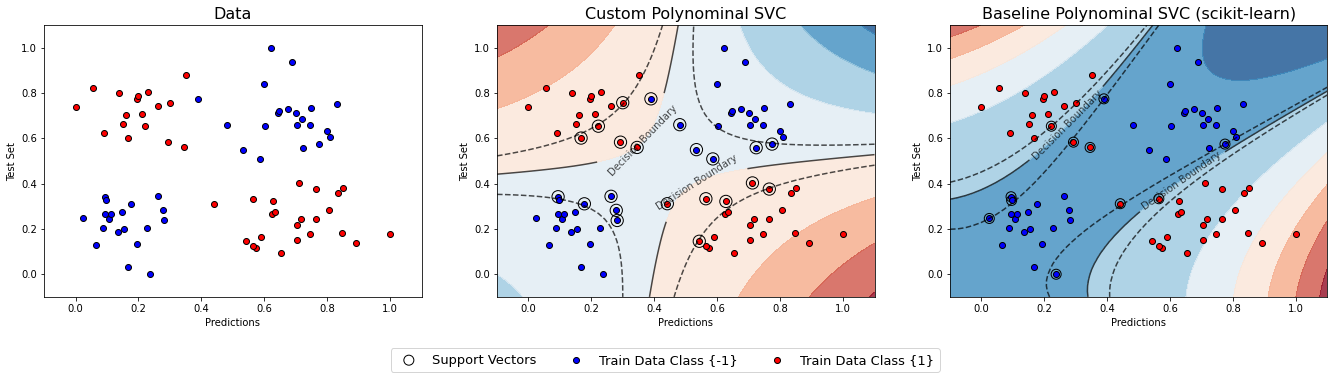

In [206]:
plot_kernel_SVC(
    X_xor_train, 
    y_xor_train, 
    [polynominal_SVC, baseline_poly_kernel_SVC],
    cmap, 
    titles=["Data", "Custom Polynominal SVC", "Baseline Polynominal SVC (scikit-learn)"], 
    kernel='polynominal')

Accuracy on test set: 95.0 %
Baseline Accuracy: 95.0 %


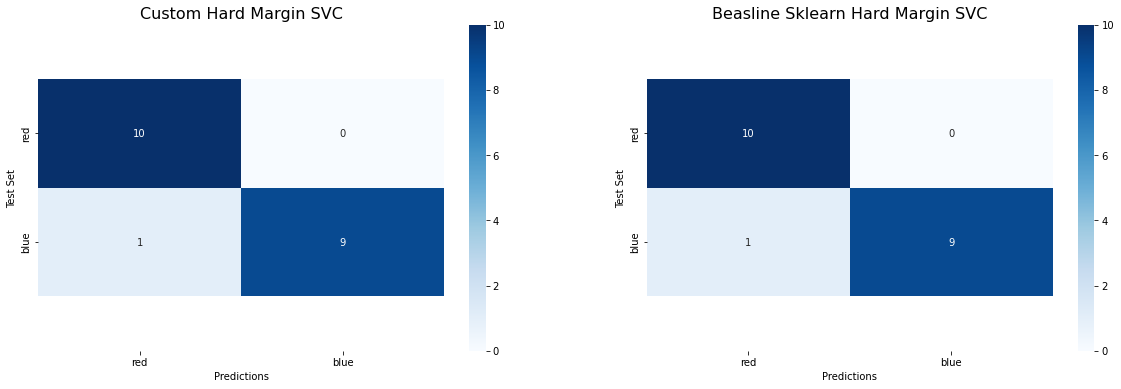

In [208]:
# accuracy
accuracy(y_xor_test, y_xor_pred_poly, True, mode='test')
print(f'Baseline Accuracy: {baseline_acc_poly*100} %')

# confusion Matrix plot
plot_confusion_matrix(
    y_xor_test, 
    y_xor_pred_poly,
    y_xor_pred_baseline_poly,
    colors, 
    titles=["Custom Hard Margin SVC", "Beasline Sklearn Hard Margin SVC"]
)

### rbf 

In [209]:
# Initialize Model
rbf_SVC = kernelSVC(None, kernel='rbf', C=10)

# Fit Model
rbf_SVC.fit(X_xor_train, y_xor_train)

SVC(kernel=rbf, C=10.0, gamma=0.5)
P: (80, 80)
q: (80, 1)
G: (160, 80)
h: (160, 1)
A: (1, 80)
b: (1, 1)
Found 49 Support Vectors out of 80 data points




100%|██████████████████████████████████████| 80/80 [00:00<00:00, 2324.49batch/s]


Accuracy on training set: 98.75 %


In [210]:
y_xor_pred_rbf = rbf_SVC.predict(X_xor_test)

100%|██████████████████████████████████████| 20/20 [00:00<00:00, 2678.87batch/s]


In [211]:
# baseline 
baseline_rbf_kernel_SVC.fit(X_xor_train, y_xor_train)

SVC(C=10, gamma=0.5)

In [212]:
y_xor_pred_baseline_rbf = baseline_rbf_kernel_SVC.predict(X_xor_test)
baseline_acc_rbf = baseline_rbf_kernel_SVC.score(X_xor_test, y_xor_test)

100%|██████████████████████████████████| 2500/2500 [00:00<00:00, 3634.58batch/s]


[[0.59823697 0.83957035]
 [0.58591827 0.50914678]
 [0.74651093 0.65701683]
 [0.60142706 0.65388642]
 [0.79975376 0.63457984]
 [0.17761776 0.31102383]
 [0.72375975 0.55862618]
 [0.26235427 0.34415076]
 [0.09408606 0.34224971]
 [0.14684107 0.27562219]
 [0.09465969 0.26663537]
 [0.09588611 0.32598036]
 [0.64339952 0.7125741 ]
 [0.64768997 0.71900791]
 [0.77415789 0.574651  ]
 [0.23745273 0.        ]
 [0.70332992 0.65735279]
 [0.53387281 0.55019374]
 [0.28195154 0.23740651]
 [0.38923594 0.77444756]
 [0.807988   0.60549636]
 [0.11361784 0.26753462]
 [0.22637291 0.20639058]
 [0.27903859 0.28208233]
 [0.48090149 0.66029826]
 [0.35160293 0.88075507]
 [0.4413334  0.31149669]
 [0.26129014 0.74429103]
 [0.3453359  0.55988482]
 [0.76556596 0.37606363]
 [0.62753629 0.32150603]
 [0.1608838  0.7033558 ]
 [0.14998696 0.66455815]
 [0.62448683 0.26421373]
 [0.29246511 0.58318028]
 [0.63427951 0.27407223]
 [0.56388852 0.3333793 ]
 [0.71194949 0.40322081]
 [0.22218445 0.65365406]
 [0.21140178 0.70895675]


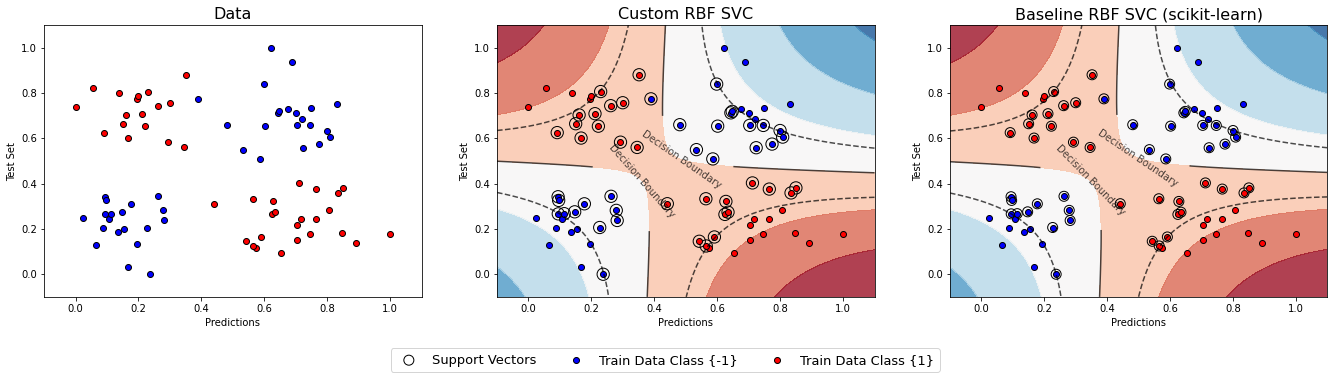

In [213]:
plot_kernel_SVC(
    X_xor_train, 
    y_xor_train, 
    [rbf_SVC, baseline_rbf_kernel_SVC], 
    cmap, 
    titles=["Data", "Custom RBF SVC", "Baseline RBF SVC (scikit-learn)"], 
    kernel='rbf')

Accuracy on test set: 100.0 %
Baseline Accuracy: 100.0 %


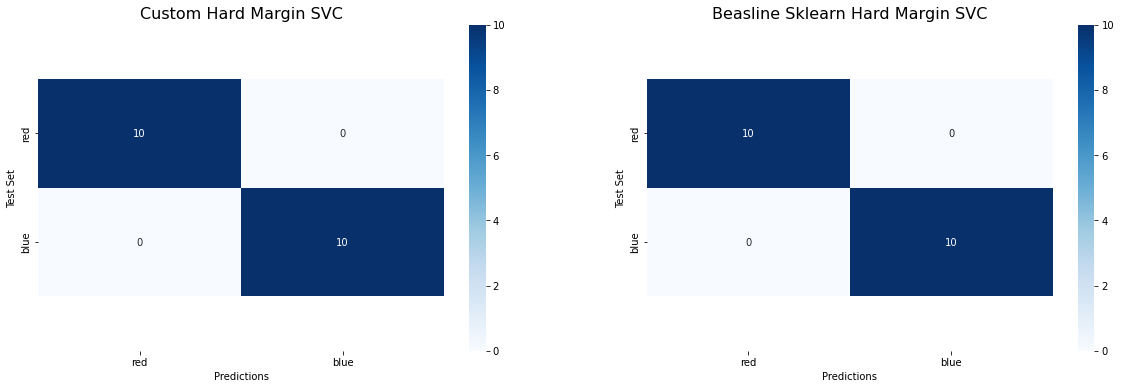

In [215]:
# accuracy
accuracy(y_xor_test, y_xor_pred_rbf, True, mode='test')
print(f'Baseline Accuracy: {baseline_acc_rbf*100} %')

# confusion Matrix plot
plot_confusion_matrix(
    y_xor_test, 
    y_xor_pred_rbf,
    y_xor_pred_baseline_rbf,
    colors, 
    titles=["Custom Hard Margin SVC", "Beasline Sklearn Hard Margin SVC"]
)

### Diasplay Kernels

In [216]:
## get kernel functions
K_linear = linear_SVC.get_kernel_matrix()
K_poly = polynominal_SVC.get_kernel_matrix()
K_rbf = rbf_SVC.get_kernel_matrix()


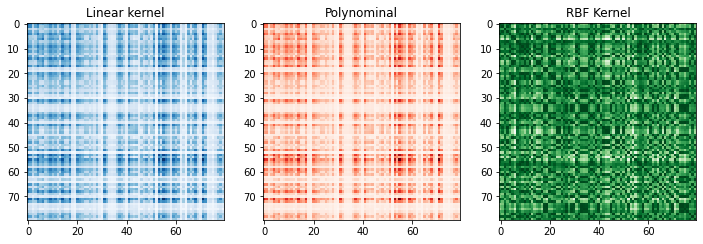

In [217]:
fig, axs = plt.subplots(1, 3, figsize=(12, 10))
axs[0].imshow(np.asmatrix(K_linear),
              interpolation='nearest', origin='upper', cmap='Blues')
axs[0].set_title("Linear kernel")
axs[1].imshow(np.asmatrix(K_poly),
              interpolation='nearest', origin='upper', cmap='Reds')
axs[1].set_title("Polynominal")
axs[2].imshow(np.asmatrix(K_rbf),
              interpolation='nearest', origin='upper', cmap='Greens')
axs[2].set_title("RBF Kernel")

plt.show()

### Quantum Kernel

In [113]:
from qiskit_machine_learning.kernels import QuantumKernel
from qiskit.circuit.library import ZZFeatureMap, PauliFeatureMap, ZFeatureMap
from qiskit import BasicAer, Aer, execute
from qiskit.utils import QuantumInstance

#### Theory
In order to use a quantum kernel, one needs to transform the classicla data to a quantum state. Such is done by ... 
#### Quantum Feature Maps 
- maps a classical state vector x to a quantum state vector (Hilbert Space)
- this is done by $$ \mathbf{U}_{\Phi}(x) = \prod_d U_{\Phi}(x)\mathbb{H}^{\otimes n}$$
**ZZ Feature Map**
$$ \mathbf{U}_{\Phi}(x) = ( \exp(i \sum_{jk} \phi_{j,k}(x) Z_j \otimes Z_k) \exp(i \sum_{j} \phi_{j}(x) Z_j)  \mathbb{H}^{\otimes n})^d$$

In [128]:
zz_map = ZZFeatureMap(feature_dimension=2, reps=2, entanglement='linear', insert_barriers=True)

#### Quantum Kernel

$$ k(x_i, x_j) = \phi^{\dagger}(x_i) \phi(x_j)$$ 
for finite data:
$$ K_{ij} = |<\phi^{\dagger}(x_i)|\phi(x_j)>|^2 $$

to calculate each element --> calc the transition amplitude 
$$ |<\phi^{\dagger}(x_i)|\phi(x_j)>|^2 = |<0^{\otimes n}|U_{\theta}^{\dagger}(x_i)|U_{\theta}(x_j)|0^{\otimes n}>|^2$$

In [129]:
zz_kernel = QuantumKernel(feature_map=zz_map, quantum_instance=Aer.get_backend('statevector_simulator'))

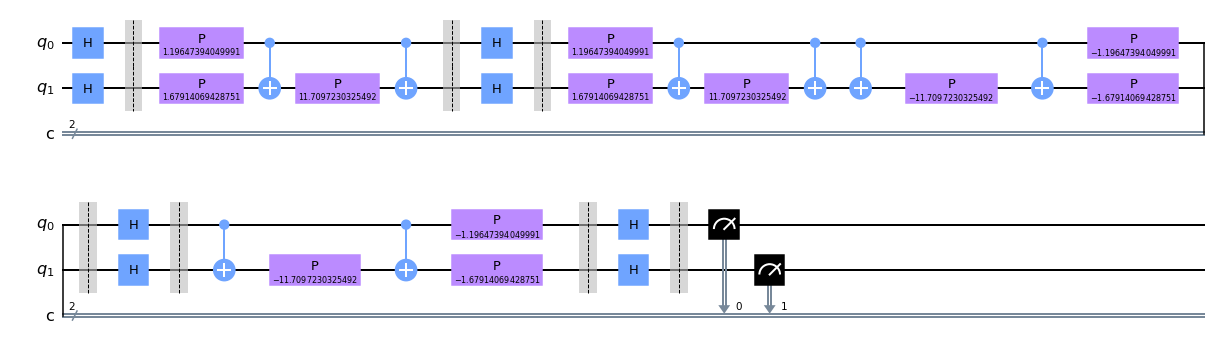

In [132]:
zz_circuit = zz_kernel.construct_circuit(X_xor_train[0])
zz_circuit.decompose().decompose().draw(output='mpl')

In [120]:
print(zz_map)

     ┌───┐ ░ ┌──────────────┐                                            ░ »
q_0: ┤ H ├─░─┤ U1(2.0*x[0]) ├──■─────────────────────────────────────■───░─»
     ├───┤ ░ ├──────────────┤┌─┴─┐┌───────────────────────────────┐┌─┴─┐ ░ »
q_1: ┤ H ├─░─┤ U1(2.0*x[1]) ├┤ X ├┤ U1(2.0*(π - x[0])*(π - x[1])) ├┤ X ├─░─»
     └───┘ ░ └──────────────┘└───┘└───────────────────────────────┘└───┘ ░ »
«     ┌───┐ ░ ┌──────────────┐                                           
«q_0: ┤ H ├─░─┤ U1(2.0*x[0]) ├──■─────────────────────────────────────■──
«     ├───┤ ░ ├──────────────┤┌─┴─┐┌───────────────────────────────┐┌─┴─┐
«q_1: ┤ H ├─░─┤ U1(2.0*x[1]) ├┤ X ├┤ U1(2.0*(π - x[0])*(π - x[1])) ├┤ X ├
«     └───┘ ░ └──────────────┘└───┘└───────────────────────────────┘└───┘


In [47]:
prep = PauliFeatureMap(2, reps=1, paulis=['ZZ'])
print(prep)

     ┌───┐                                           
q_0: ┤ H ├──■─────────────────────────────────────■──
     ├───┤┌─┴─┐┌───────────────────────────────┐┌─┴─┐
q_1: ┤ H ├┤ X ├┤ U1(2.0*(π - x[0])*(π - x[1])) ├┤ X ├
     └───┘└───┘└───────────────────────────────┘└───┘


In [48]:
prep = ZFeatureMap(2, reps=2)
print(prep)

     ┌───┐┌──────────────┐┌───┐┌──────────────┐
q_0: ┤ H ├┤ U1(2.0*x[0]) ├┤ H ├┤ U1(2.0*x[0]) ├
     ├───┤├──────────────┤├───┤├──────────────┤
q_1: ┤ H ├┤ U1(2.0*x[1]) ├┤ H ├┤ U1(2.0*x[1]) ├
     └───┘└──────────────┘└───┘└──────────────┘


In [49]:
# simulate 
backend = Aer.get_backend('qasm_simulator')
job = execute(zz_circuit, backend, shots=8192, seed_simulator=1024, see_transpiler=1024)
counts= job.result().get_counts(zz_circuit)

# calc transition amplitude
counts['00']/sum(counts.values())

0.8216552734375

#### Implementation in SVC

In [54]:
from qiskit import QuantumCircuit, IBMQ, execute

provider = IBMQ.load_account()
provider.backends()

[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_armonk') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_santiago') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_bogota') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_lima') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_belem') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_quito') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_statevector') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_mps') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_extended_stabilizer') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_stabilizer') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_m

In [55]:
backend_qasm = provider.get_backend('ibmq_qasm_simulator')
backend_santiago = provider.get_backend('ibmq_santiago')
state_vector_sim = provider.get_backend('simulator_statevector')

In [56]:
quantum_params = {
    'feature_dimension': 2,
    'reps': 2,
    'seed': 10596,
    'shots': 1024,   
    'provider_backend': None,
}

In [57]:
# set up quntum kernel 
quantum_SVC = kernelSVC(quantum_params, kernel='quantum')

SVC(kernel=quantum)


In [60]:
# train 
quantum_SVC.fit(X_xor_train, y_xor_train)

Computing Quantum Kernel ...
Quantum Kernel computed!
Found 7 Support Vectors out of 80 data points




100%|████████████████████████████████████████| 80/80 [01:11<00:00,  1.11batch/s]


Accuracy on training set: 100.0 %


100%|██████████████████████████████████████| 400/400 [10:41<00:00,  1.60s/batch]


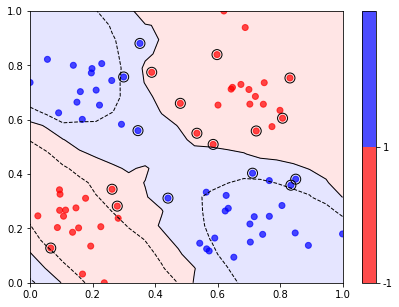

In [123]:
#quantum_kernelSVC.plot(X_xor_train, y_xor_train, cmap)

In [61]:
y_xor_pred_quantum = quantum_SVC.predict(X_xor_test)

100%|████████████████████████████████████████| 20/20 [00:19<00:00,  1.04batch/s]


In [107]:
# baseline
QK = quantum_kernel_loader(quantum_params)
baseline_quantum_kernel_SVC = SVC(kernel=QK)
baseline_quantum_kernel_SVC.fit(X_xor_train, y_xor_train)

SVC(kernel=<bound method QuantumKernel.evaluate of <qiskit_machine_learning.kernels.quantum_kernel.QuantumKernel object at 0x7fc849b83890>>)

In [108]:
y_xor_pred_baseline_quantum = baseline_quantum_kernel_SVC.predict(X_xor_test)
baseline_acc_quantum = baseline_quantum_kernel_SVC.score(X_xor_test, y_xor_test)

100%|██████████████████████████████████████| 400/400 [06:45<00:00,  1.01s/batch]


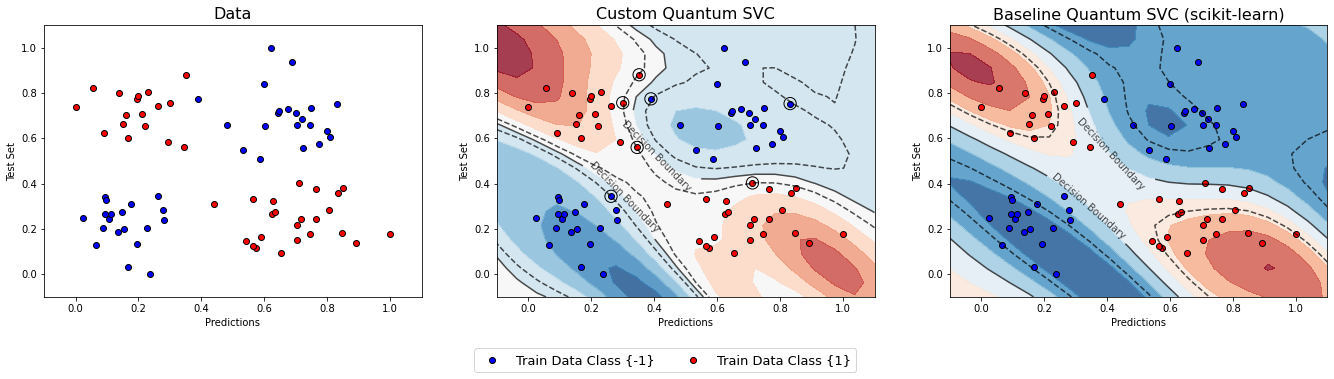

In [103]:
plot_kernel_SVC(
    X_xor_train, 
    y_xor_train, 
    [quantum_SVC, baseline_quantum_kernel_SVC], 
    cmap, 
    titles=["Data", "Custom Quantum SVC", "Baseline Quantum SVC (scikit-learn)"], 
    kernel='quantum')

In [109]:
# baseline
QK = quantum_kernel(quantum_params)
Q_train = QK(X_xor_train)

baseline_quantum_kernel_SVC_pre = SVC(kernel='precomputed')
baseline_quantum_kernel_SVC_pre.fit(Q_train, y_xor_train)

SVC(kernel='precomputed')

100%|██████████████████████████████████████| 400/400 [06:46<00:00,  1.02s/batch]


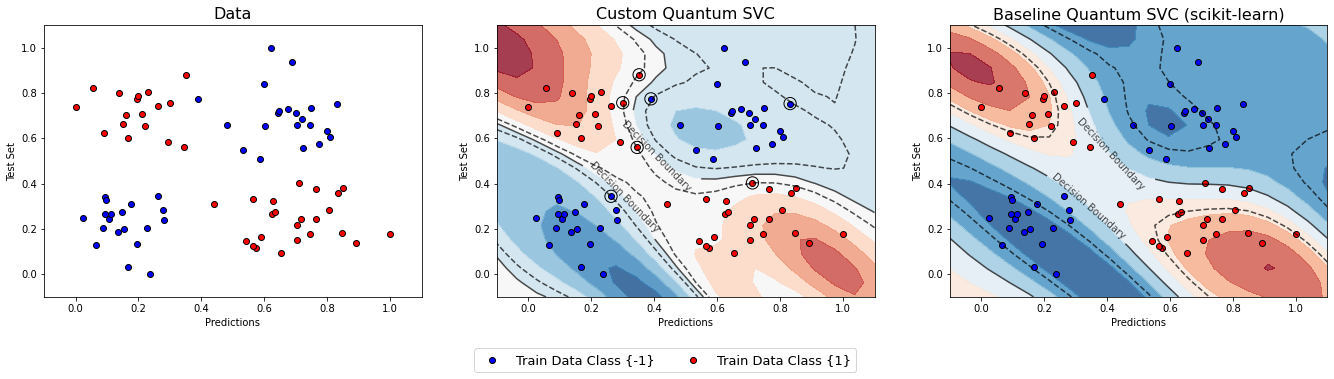

In [110]:
plot_kernel_SVC(
    X_xor_train, 
    y_xor_train, 
    [quantum_SVC, baseline_quantum_kernel_SVC], 
    cmap, 
    titles=["Data", "Custom Quantum SVC", "Baseline Quantum SVC (scikit-learn)"], 
    kernel='quantum')

Accuracy on test set: 100.0 %
Baseline Accuracy: 95.0 %


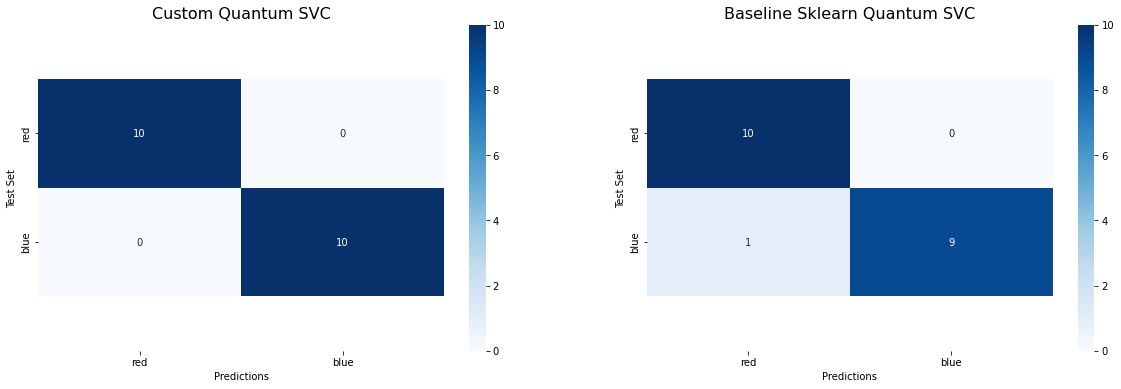

In [58]:
# accuracy
accuracy(y_xor_test, y_xor_pred_quantum, mode='test')
print(f'Baseline Accuracy: {baseline_acc_quantum*100} %')

# confusion Matrix plot
plot_confusion_matrix(
    y_xor_test, 
    y_xor_pred_quantum,
    y_xor_pred_baseline_quantum,
    colors, 
    titles=["Custom Quantum SVC", "Baseline Sklearn Quantum SVC"]
)

In [59]:
QK_train = QK(X_xor_train)
QK_test = QK(X_xor_test, y_xor_test)

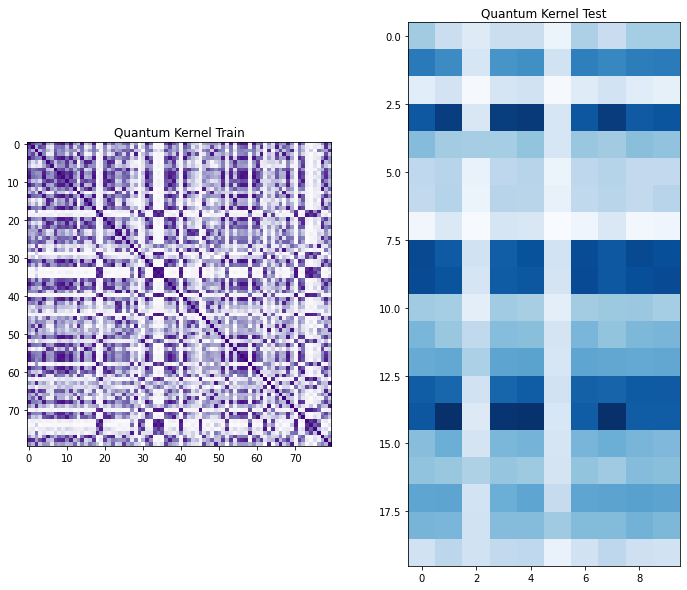

In [60]:
fig, ax = plt.subplots(1, 2, figsize=(12, 10))
ax[0].imshow(np.asmatrix(QK_train),
              interpolation='nearest', origin='upper', cmap='Purples')
ax[0].set_title("Quantum Kernel Train")
ax[1].imshow(np.asmatrix(QK_test),
              interpolation='nearest', origin='upper', cmap='Blues')
ax[1].set_title("Quantum Kernel Test")
plt.show()

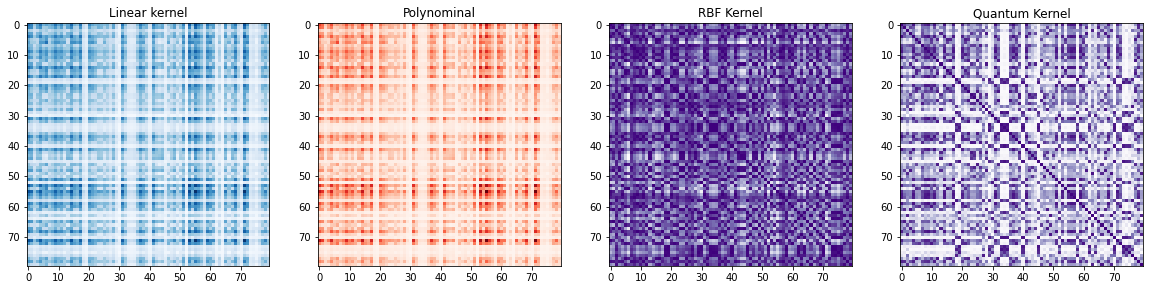

In [61]:
fig, axs = plt.subplots(1, 4, figsize=(20, 20))
axs[0].imshow(np.asmatrix(K_linear),
              interpolation='nearest', origin='upper', cmap='Blues')
axs[0].set_title("Linear kernel")
axs[1].imshow(np.asmatrix(K_poly),
              interpolation='nearest', origin='upper', cmap='Reds')
axs[1].set_title("Polynominal")
axs[2].imshow(np.asmatrix(K_rbf),
              interpolation='nearest', origin='upper', cmap='Purples')
axs[2].set_title("RBF Kernel")
axs[3].imshow(np.asmatrix(QK_train),
              interpolation='nearest', origin='upper', cmap='Purples')
axs[3].set_title("Quantum Kernel")
plt.show()

#### Another example

In [16]:
from qiskit_machine_learning.datasets import ad_hoc_data
from qiskit.utils import algorithm_globals

In [17]:
adhoc_dimension = 2
train_features, train_labels, test_features, test_labels, adhoc_total = ad_hoc_data(
    training_size=40,
    test_size=10,
    n=adhoc_dimension,
    gap=0.3,
    plot_data=False, one_hot=False, include_sample_total=True
)

In [28]:
train_features, train_labels, test_features, test_labels, adhoc_total = datasets[-1]

In [29]:
#from svm.utils.utils import normalize

#train_features, train_labels, test_features, test_labels, adhoc_total = normalize(train_features), normalize(train_labels), normalize(test_features), normalize(test_labels), normalize(adhoc_total)

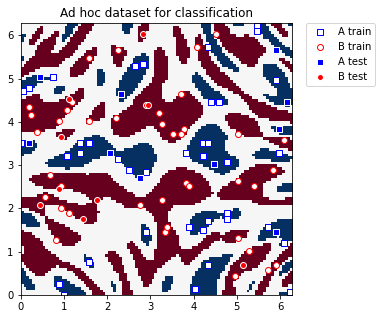

In [30]:
plt.figure(figsize=(5, 5))
plt.ylim(0, 2 * np.pi)
plt.xlim(0, 2 * np.pi)
plt.imshow(np.asmatrix(adhoc_total).T, interpolation='nearest',
           origin='lower', cmap='RdBu', extent=[0, 2 * np.pi, 0, 2 * np.pi])

plt.scatter(train_features[np.where(train_labels[:] == -1), 0], train_features[np.where(train_labels[:] == -1), 1],
            marker='s', facecolors='w', edgecolors='b', label="A train")
plt.scatter(train_features[np.where(train_labels[:] == 1), 0], train_features[np.where(train_labels[:] == 1), 1],
            marker='o', facecolors='w', edgecolors='r', label="B train")
plt.scatter(test_features[np.where(test_labels[:] == -1), 0], test_features[np.where(test_labels[:] == -1), 1],
            marker='s', facecolors='b', edgecolors='w', label="A test")
plt.scatter(test_features[np.where(test_labels[:] == 1), 0], test_features[np.where(test_labels[:] == 1), 1],
            marker='o', facecolors='r', edgecolors='w', label="B test")

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.title("Ad hoc dataset for classification")

plt.show()

In [31]:
train_labels

array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1])

In [33]:
# baseline 
adhoc_basline_rbf = baseline_rbf_kernel_SVC
adhoc_basline_rbf.fit(train_features, train_labels)

SVC(C=10, gamma=0.5)

In [34]:
#y_xor_train, train_labels.asty

In [35]:
adhoc_rbf_SVC = kernelSVC(None, kernel='rbf', C=10)

adhoc_rbf_SVC.fit(train_features, train_labels.astype(np.float))

/Users/Maxi/.virtualenvs/svm_venv/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  This is separate from the ipykernel package so we can avoid doing imports until


SVC(kernel=rbf, C=10.0, gamma=0.5)
P: (80, 80)
q: (80, 1)
G: (160, 80)
h: (160, 1)
A: (1, 80)
b: (1, 1)
Found 57 Support Vectors out of 80 data points




100%|██████████████████████████████████████| 80/80 [00:00<00:00, 1876.84batch/s]


Accuracy on training set: 91.25 %


6.220353454107791 6.157521601035994


100%|██████████████████████████████████| 2500/2500 [00:00<00:00, 3262.74batch/s]


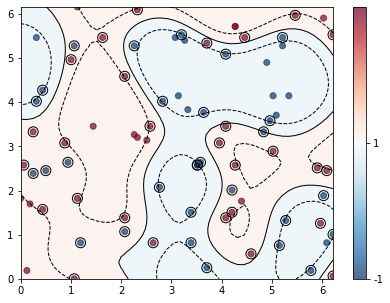

In [228]:
adhoc_rbf_SVC.plot(train_features, train_labels, cmap)

In [229]:
y_adhoc_pred_rbf = adhoc_rbf_SVC.predict(test_features)

accuracy(test_labels, y_adhoc_pred_rbf, True, mode='test')

100%|██████████████████████████████████████| 20/20 [00:00<00:00, 2251.43batch/s]

Accuracy on test set: 65.0 %


100%|██████████████████████████████████| 2500/2500 [00:00<00:00, 3109.89batch/s]


[[5.15221195 0.75398224]
 [2.76460154 2.07345115]
 [5.78053048 0.18849556]
 [0.50265482 2.45044227]
 [6.03185789 1.88495559]
 [4.20973416 2.0106193 ]
 [3.58141563 2.63893783]
 [3.64424748 3.76991118]
 [2.07345115 1.0681415 ]
 [5.2150438  5.46637122]
 [3.70707933 0.25132741]
 [3.39292007 1.50796447]
 [2.26194671 5.27787566]
 [3.39292007 0.81681409]
 [1.19380521 0.81681409]
 [3.20442451 5.52920307]
 [0.31415927 4.0212386 ]
 [3.51858377 2.57610598]
 [0.9424778  2.63893783]
 [2.82743339 4.0212386 ]
 [4.83805269 3.33008821]
 [0.25132741 2.38761042]
 [4.96371639 3.58141563]
 [0.43982297 4.27256601]
 [4.08407045 5.0893801 ]
 [5.27787566 1.31946891]
 [1.0681415  5.27787566]
 [6.22035345 1.00530965]
 [3.51858377 2.57610598]
 [4.46106157 5.46637122]
 [2.07345115 1.38230077]
 [4.08407045 1.38230077]
 [3.70707933 5.34070751]
 [1.0681415  0.        ]
 [3.95840674 3.0787608 ]
 [0.43982297 1.57079633]
 [6.22035345 5.52920307]
 [0.25132741 3.33008821]
 [4.27256601 2.57610598]
 [4.20973416 1.50796447]


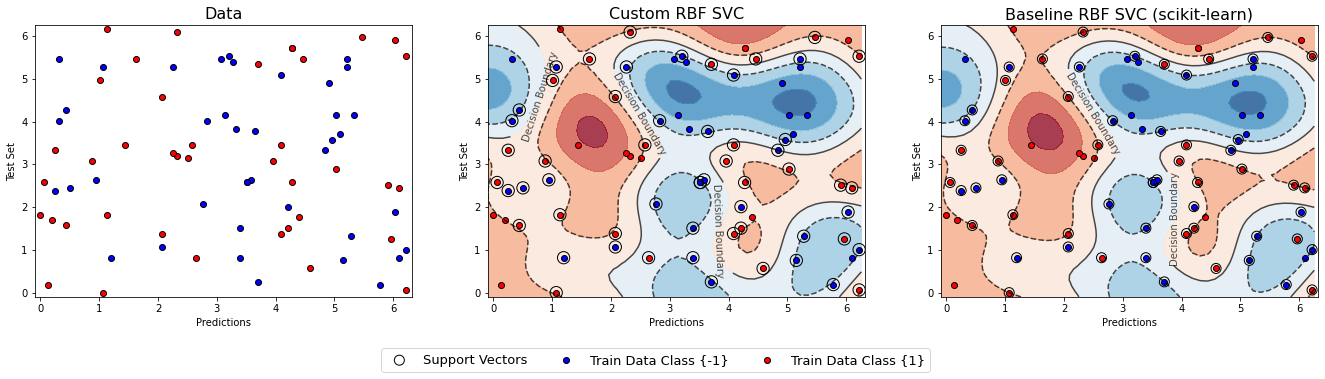

In [233]:
plot_kernel_SVC(
    train_features, 
    train_labels, 
    [adhoc_rbf_SVC, adhoc_basline_rbf], 
    cmap, 
    titles=["Data", "Custom RBF SVC", "Baseline RBF SVC (scikit-learn)"], 
    kernel='rbf')

In [75]:
# set up quntum kernel 
quantum_kernelSVC = kernelSVC(quantum_params, kernel='quantum')

SVC(kernel=quantum)


In [76]:
quantum_kernelSVC.fit(train_features, train_labels.astype(np.float))

/Users/Maxi/.virtualenvs/svm_venv/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """Entry point for launching an IPython kernel.


Computing Quantum Kernel ...
Quantum Kernel computed!
Found 23 Support Vectors out of 80 data points




100%|████████████████████████████████████████| 80/80 [03:35<00:00,  2.69s/batch]


Accuracy on training set: 100.0 %


In [77]:
#quantum_kernelSVC.plot(X_xor_train, y_xor_train, cmap)

In [78]:
y_adhoc_pred_quantum = quantum_kernelSVC.predict(test_features)

accuracy(test_labels, y_adhoc_pred_quantum, mode='test')

100%|████████████████████████████████████████| 20/20 [00:50<00:00,  2.53s/batch]

Accuracy on test set: 100.0 %


In [137]:
from quantum_svm.utils.utils import compare_models
from timeit import timeit
# linear, poly, sigmoid, rbf, qunatum  

In [138]:
classifiers = [
    kernelSVC(kernel='linear', C=10, verbose=False),
    kernelSVC(kernel='polynominal', C=10, verbose=False),
    kernelSVC(kernel='sigmoid', C=10, verbose=False),
    kernelSVC(kernel='rbf', C=10, verbose=False),
    kernelSVC(kernel='rbf', C=1000, verbose=False)
]

SVC(kernel='linear', C=10.0)
SVC(kernel='polynominal', C=10.0, degree=3)
SVC(kernel='sigmoid', C=10.0, gamma=0.5)
SVC(kernel='rbf', C=10.0, gamma=0.5)
SVC(kernel='rbf', C=1000.0, gamma=0.5)


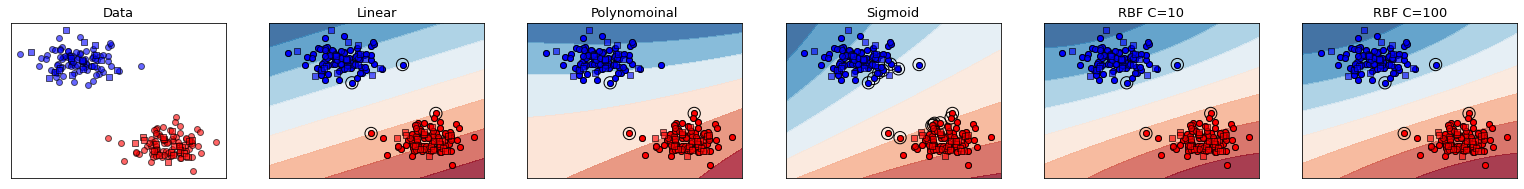

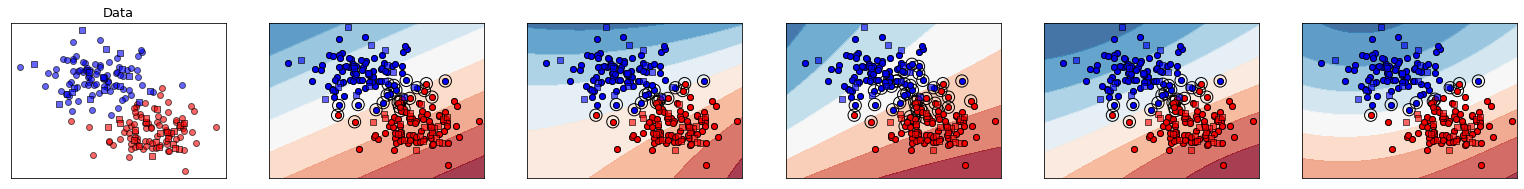

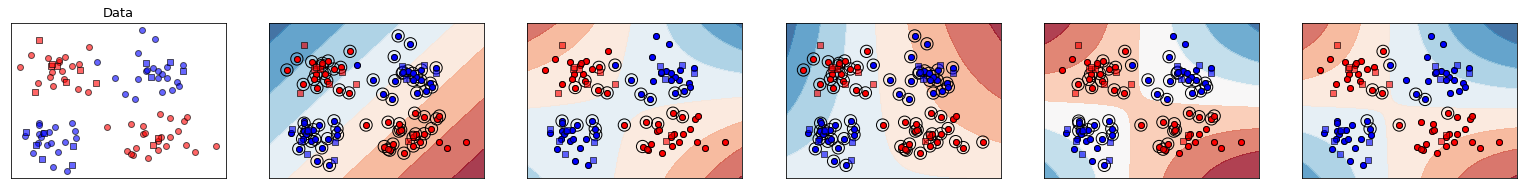

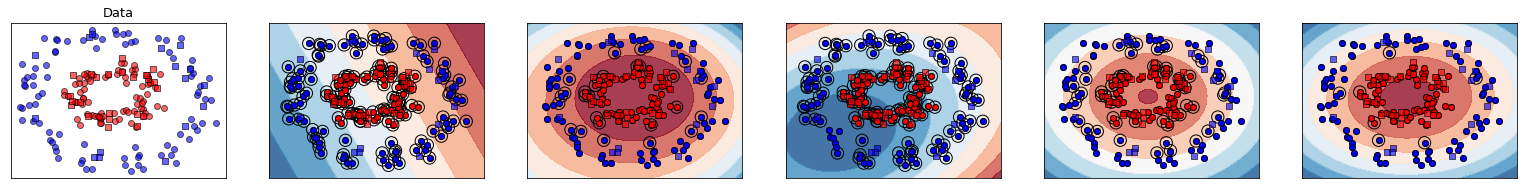

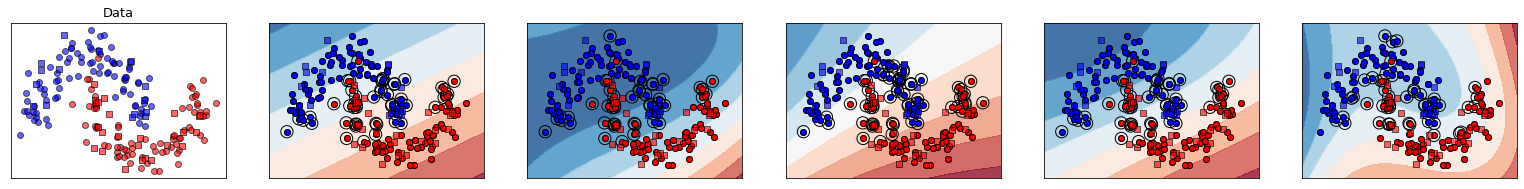

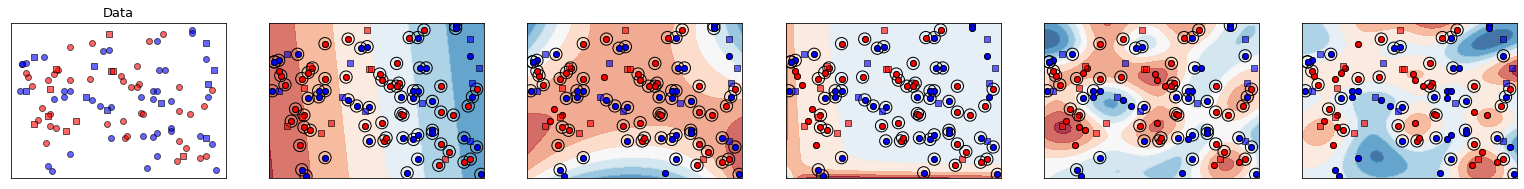

Time to compute: 0.4850567499796549 min


In [139]:
compare_models(
    datasets, 
    classifiers, 
    ['Linear', 'Polynomoinal', 'Sigmoid', 'RBF C=10', 'RBF C=100'],
)


In [140]:
QK = quantum_kernel(quantum_params)

classifiers = [
    SVC(kernel='linear', C=10),
    SVC(kernel='poly', C=10, degree=3),
    SVC(kernel='sigmoid', C=10, gamma=0.5),
    SVC(kernel='rbf', C=10, gamma=0.5),
    SVC(kernel='rbf', C=1000, gamma=0.5),
    SVC(kernel=QK),
]

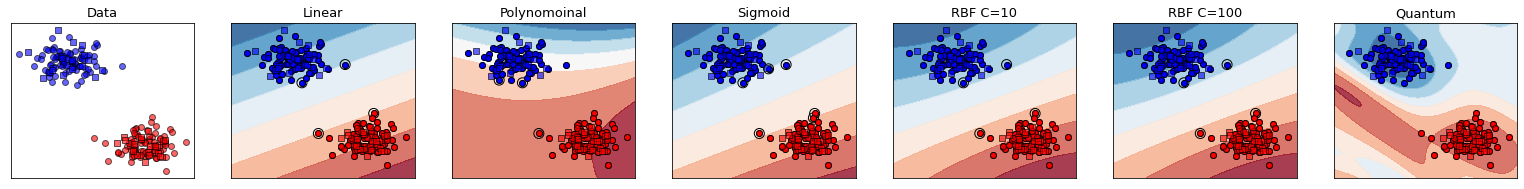

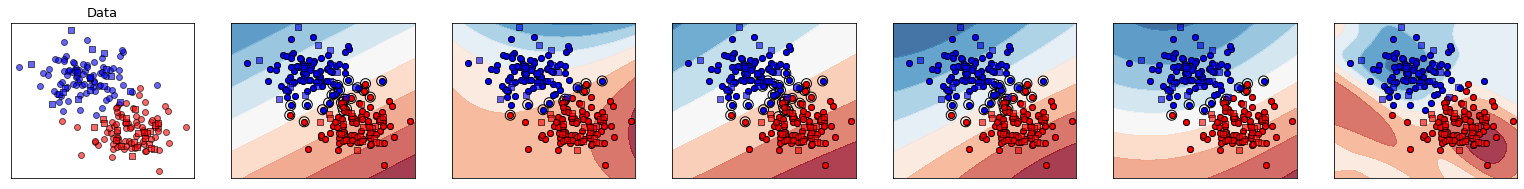

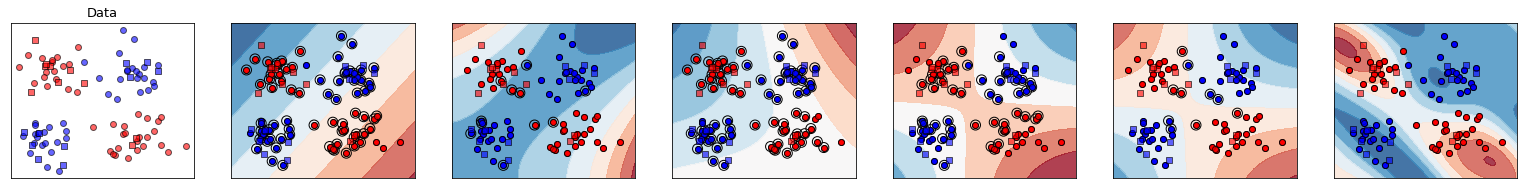

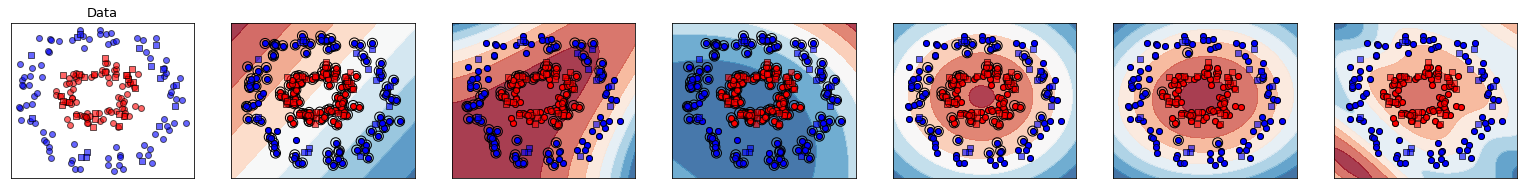

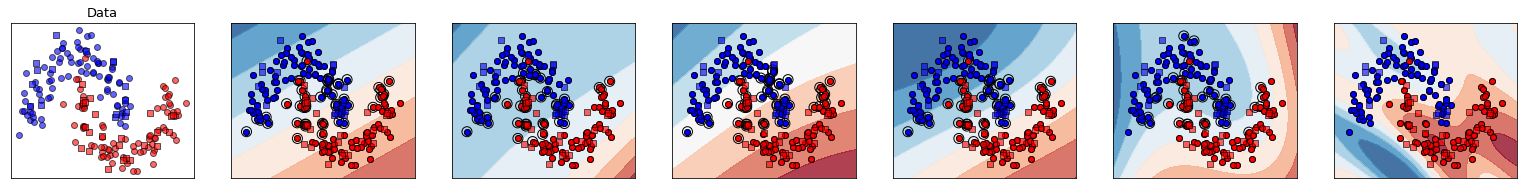

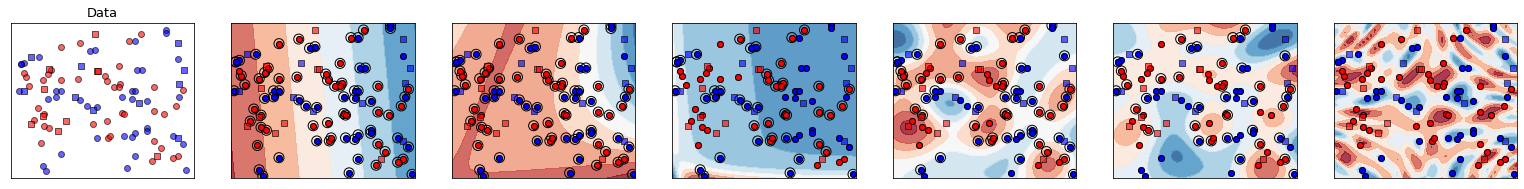

Time to compute: 6.443527567386627 min


In [141]:
compare_models(
    datasets, 
    classifiers,
    ['Linearly Separately Data', 'Linearly Separately Data', 'XOR Data', 'Circles Data', 'Moons Data', 'Adhoc Data'],
    ['Linear', 'Polynomoinal', 'Sigmoid', 'RBF C=10', 'RBF C=100', 'Quantum'], 
    scikit=True
)

## Resources 

https://www.youtube.com/watch?v=GVhCOTzAkCM

https://arxiv.org/pdf/1804.11326.pdf

https://www.moodle.tum.de/pluginfile.php/3272161/mod_resource/content/1/Quantum%20Machine%20Learning%20in%20Feature%20Hilbert%20Spaces%20-%20PRL%202019.pdf

https://qiskit.org/documentation/stable/0.19/_modules/index.html